### install some packages

In [ ]:
!sudo apt-get install gcc python3-dev python3-setuptools


## Read the raw data and load pandas dataframe

In [ ]:
# assuming that 2022001-365.db is uploaded to the waveforms directory

### Open the SQLite database and query the rows into a pandas dataframe.

#### Read data from sqlite

Visualize and build a model on the data in the file 2022001-365.db. This file has 1 year's worth of data for 2022. The data was created with the following table structure:

```
CREATE TABLE arrival_waveform (
  arid INTEGER,
  sta TEXT,
  chan TEXT,
  phase TEXT,
  snr REAL,
  amp REAL,
  per REAL,
  delta REAL,
  timeres REAL,
  orid INTEGER,
  mb REAL,
  ml REAL,
  ndef INTEGER,
  time_difference REAL,
  sampling_rate INTEGER,
  data BLOB
)
```
- Each row in this table represents one arrival that was detected by both the automatic DFX arrivals and by the analysts. The `data` colunn refers to the waveform data centered at the DFX arrival time and stored as a JSON list.
- The column `time_difference` is the difference in time between the leb arrival time and DFX arrival time.
- `sampling_rate` is the number of samples per second in the data blob.
- `timeres` is the DFX arrival time minus the theoretical arrival time.

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import json

def read_dataframe_from_sqlite(query):
  conn = sqlite3.connect("/content/waveforms/2022001-365.db")
  curs = conn.execute(query)
  colnames = [col[0] for col in curs.description]
  # find which column has the `data` if any
  if "data" in colnames:
    dataidx = colnames.index("data")
  else:
    dataidx = -1
  rows = curs.fetchall()
  for idx in range(len(rows)):
    row = list(rows[idx])
    # if the data is selected then convert the waveform from a json string to a numpy array
    if dataidx >= 0:
      row[dataidx] = np.array(json.loads(row[dataidx]), dtype='float64')
    rows[idx] = row
  curs.close()
  conn.close()
  df = pd.DataFrame(rows, columns = colnames)
  # rename some of the columns to make them easier to work with
  rename_columns = {}
  if "time_difference" in colnames:
    rename_columns["time_difference"] = "td"
  if "sampling_rate" in colnames:
    rename_columns["sampling_rate"] = "sr"
  if len(rename_columns):
    df.rename(columns = rename_columns, inplace=True)
  del rows
  del curs
  del conn
  return df

#### Query rows with time difference < 5 and ndef > 10 and snr > 10

In [ ]:
#SAMPLING_RATE=40
#NUM_DATA_SAMPLES=10000

#df = read_dataframe_from_sqlite(f"select * from arrival_waveform where sampling_rate={SAMPLING_RATE} and abs(time_difference)<5 and abs(timeres)<5 and ndef>10 and snr > 10 limit {NUM_DATA_SAMPLES}")
#df.head()

In [ ]:
#import numpy as np
#df.assign(data=np.nan).to_csv("10k-snr10-sr40-ndef10.csv")
#np.save("10k-snr10-sr40-ndef10.data.npy", df.data.values)

In [ ]:
#!gsutil cp 10k-snr10-sr40-ndef10.* gs://netvisa-parameteric-data/waveforms/

#### Query rows with abs(td) < .25

In [ ]:
SAMPLING_RATE=40
NUM_DATA_SAMPLES=100000

df = read_dataframe_from_sqlite(f"select * from arrival_waveform where sampling_rate={SAMPLING_RATE} and abs(time_difference)<.25 and ndef>10 and snr > 10 limit {NUM_DATA_SAMPLES}")
df.head()

,arid,sta,elem,chan,phase,snr,amp,per,delta,timeres,orid,mb,ml,ndef,td,sr,data
0,168640172,ILAR,IL31,BHZ,PcP,10.656312,3.825157,0.666667,66.565245,0.213785,21967806,4.524920,-999.000000,74,0.0,40,"[-104.028672, -103.532352, -102.887136, -102.2..."
1,168641199,FRB,FRB,BHZ,P,40.209732,4.378668,0.444444,90.172847,-0.245343,21967806,4.524920,-999.000000,74,0.0,40,"[-355.30723439999997, -356.6966505, -358.08606..."
2,168645390,YKA,YKAR8,SHZ,P,22.842827,0.944155,0.666667,58.369308,-0.450919,21962490,4.166156,-999.000000,31,0.0,40,"[-60.5886108, -60.5847299, -60.592491700000004..."
3,168648613,HILR,HIB1,BHZ,P,12.204271,14.252265,0.666667,23.205020,1.035261,21967200,4.646000,3.259946,58,0.0,40,"[-2.0592, -0.6006, 8.151, 6.9498, 2.574, 6.091..."
4,168635562,ASAR,AS31,BHZ,P,30.544380,2.073614,0.666667,40.242264,0.578814,21962557,4.112298,4.473159,23,0.0,40,"[-8.30407, 0.6054, 15.04419, 12.27953, -1.5437..."


In [ ]:
#import numpy as np
#df.assign(data=np.nan).to_csv("10k-snr10-sr40-ndef10-td0.csv")
#np.save("10k-snr10-sr40-ndef10-td0.data.npy", df.data.values)


In [ ]:
#!gsutil cp 10k-snr10-sr40-ndef10-td0.* gs://netvisa-parameteric-data/waveforms/

## Directly download one of the pre-saved pandas dataframe.

In [ ]:
#!gsutil cp  gs://netvisa-parameteric-data/waveforms/10k-snr10-sr40-ndef10-td0.* .

In [ ]:
#import pandas as pd
#import numpy as np
#df = pd.read_csv("10k-snr10-sr40-ndef10-td0.csv")
#df.data = np.load("10k-snr10-sr40-ndef10-td0.data.npy", allow_pickle=True)

## Visualize a few of the waveforms

In [ ]:
import scipy.signal

def bandpass(low_freq, high_freq, sr, data):
  """
  low_freq
  high_freq
  sr - sampling rate
  data - data samples

  Bandpass the signal between the low and high frequency
  """
  # apply a 3-pole bandpass filter
  b, a = scipy.signal.butter(3, [low_freq * 2 /sr, high_freq * 2 / sr], 'band')
  # We use lfilter which is a causal filter that is better suited for onset detection
  # as opposed to filtfilt
  filtered = scipy.signal.lfilter(b, a, data)
  return filtered

In [ ]:
import numpy as np
def create_triangle(num_points, sample_rate, offset):
  curve = np.zeros(num_points)
  mid = int(num_points // 2 + offset * sample_rate)
  start = mid - sample_rate // 2
  end = mid + sample_rate // 2
  curve[start+1:mid+1] = np.linspace(0, 1, sample_rate // 2)
  curve[mid:end] = np.linspace(1, 0, sample_rate // 2)
  return curve


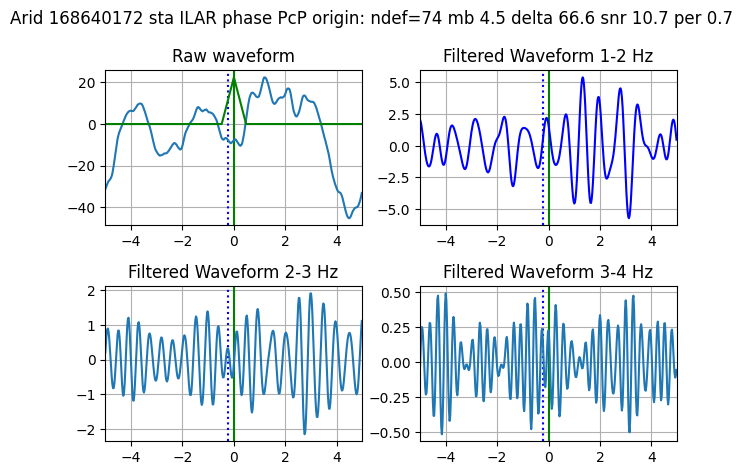

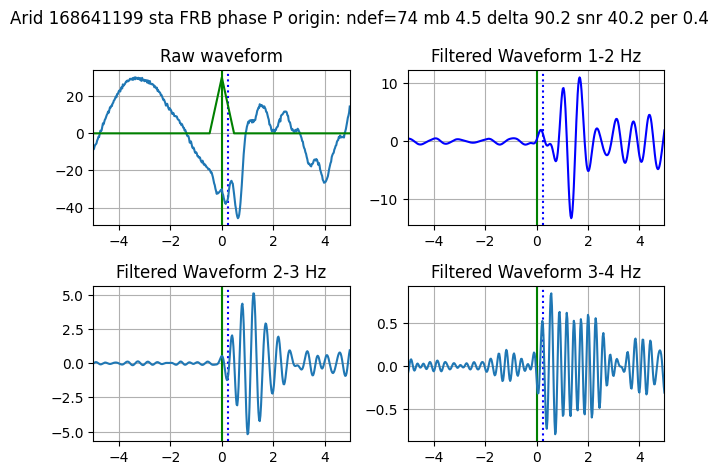

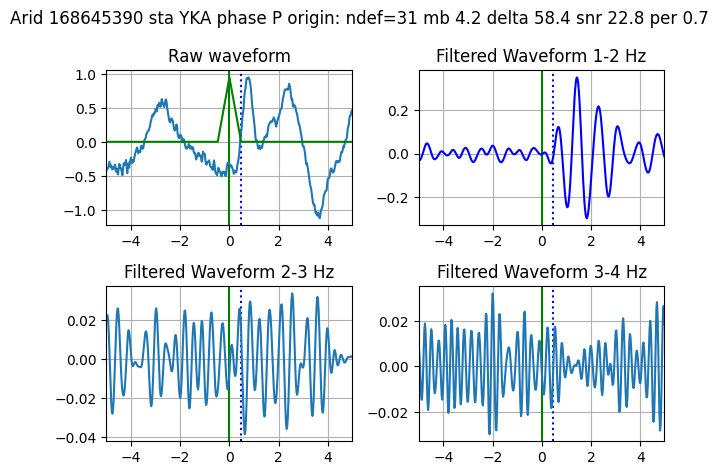

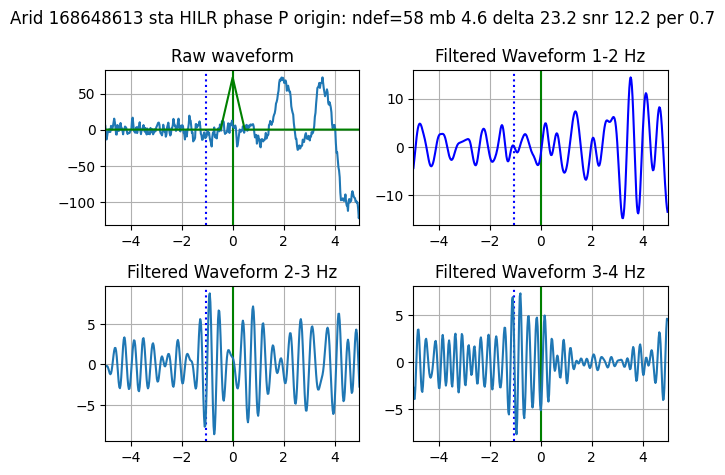

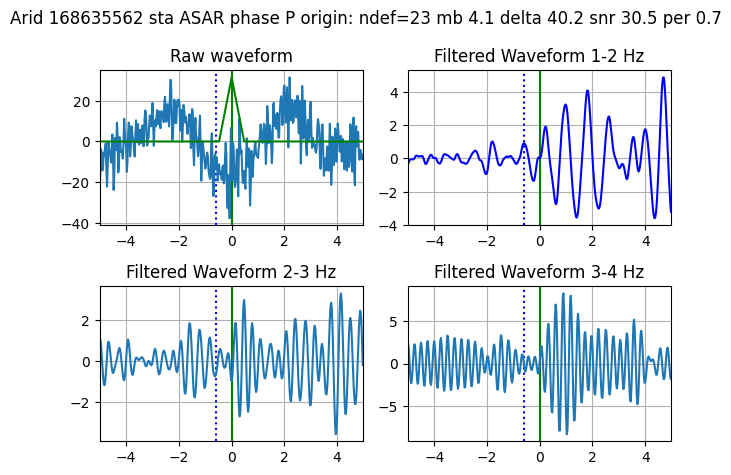

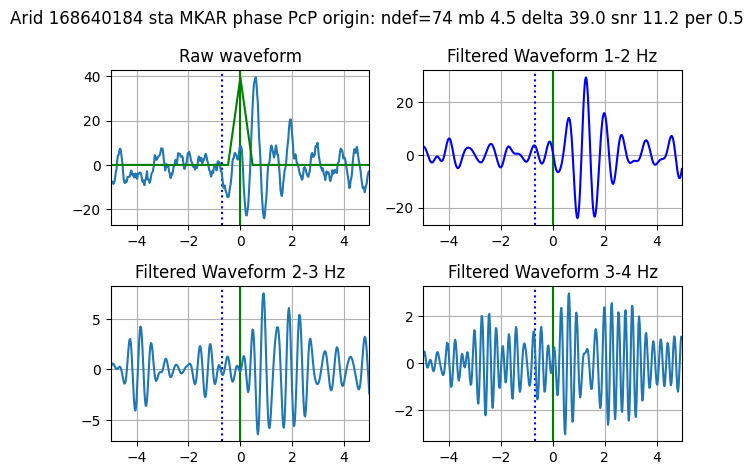

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

idx = 0
#for _, row in df.query('abs(td) < 0.1').iterrows():
for _, row in df.iterrows():
  times = np.arange(len(row.data))/row.sr - len(row.data)/2/row.sr
  trim = 25*row.sr # trim off 25 seconds of the waveform on both ends

  data = scipy.signal.detrend(row.data)

  plt.figure()
  plt.suptitle(
    f"Arid {row.arid} sta {row.sta} phase {row.phase}"
    f" origin: ndef={row.ndef} mb {row.mb:.1f} delta {row.delta:.1f}"
    f" snr {row.snr:.1f} per {row.per:.1f}")
  plt.subplot(221)
  plt.axvline(x = row.td, color = 'g', ls = '-', label='LEB')
  plt.axvline(x = -row.timeres, ls = ':', color = 'b', label='Theoretical')
  plt.plot(times[trim:-trim], data[trim:-trim])
  plt.plot(times[trim:-trim], create_triangle(len(data), row.sr, row.td)[trim:-trim] * data[trim:-trim].max(), color='g')
  plt.title("Raw waveform")
  plt.grid(True)
  plt.margins(0, .05)

  plt.subplot(222)
  plt.title("Filtered Waveform 1-2 Hz")
  plt.axvline(x = row.td, color = 'g', label='LEB')
  plt.axvline(x = -row.timeres, ls = ':', color = 'b', label='Theoretical')
  plt.plot(times[trim:-trim], bandpass(1, 2, row.sr, row.data)[trim:-trim], color='b')
  plt.grid(True)
  plt.margins(0, .05)

  plt.subplot(223)
  plt.title("Filtered Waveform 2-3 Hz")
  plt.axvline(x = row.td, color = 'g', label='LEB')
  plt.axvline(x = -row.timeres, ls = ':', color = 'b', label='Theoretical')
  plt.plot(times[trim:-trim], bandpass(2, 3, row.sr, row.data)[trim:-trim])
  plt.grid(True)
  plt.margins(0, .05)

  plt.subplot(224)
  plt.title("Filtered Waveform 3-4 Hz")
  plt.axvline(x = row.td, color = 'g', label='LEB')
  plt.axvline(x = -row.timeres, ls = ':', color = 'b', label='Theoretical')
  plt.plot(times[trim:-trim], bandpass(3, 4, row.sr, row.data)[trim:-trim])
  plt.grid(True)
  plt.margins(0, .05)

  plt.tight_layout()
  plt.show()

  idx += 1
  if idx > 5:
    break

## Create a Dataset

In [ ]:
#from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
import scipy.signal
import torch

class WaveformDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, transform=None):
      """
      Arguments:
          df (Pandas dataframe)
          transform (callable, optional): Optional transform to be applied
              on a sample.
      """
      torch.manual_seed(42)
      unif = torch.distributions.Uniform(5, 15)
      self.dataset = []
      for idx, row in df.iterrows():
        # offset in 5 to 15 where the signal arrives
        offset = int(unif.sample() * row.sr)
        data = scipy.signal.detrend(row.data)
        start = len(data) // 2  + int(row.td * row.sr) - offset
        end = start + 20 * row.sr
        self.dataset.append((data[start:end], offset, row.sr))
      self.transform = transform

    def __len__(self):
      return len(self.dataset)

    def create_triangle(self, num_points, offset, sr):
      curve = np.zeros(num_points)
      curve[offset - sr // 2: offset] = np.linspace(0, 1, sr // 2)
      curve[offset: offset + sr // 2] = np.linspace(1, 0, sr // 2)
      return curve

    def __getitem__(self, idx):
      waveform, offset, sr = self.dataset[idx]
      signal = self.create_triangle(len(waveform), offset, sr)
      sample = {
          'offset': offset,
          'waveform': torch.from_numpy(waveform),
          'output': torch.from_numpy(signal),
          'sr': sr
      }
      if self.transform:
        sample = self.transform(sample)
      return sample

def plot_sample(waveform, output, offset, sr):
  waveform = bandpass(1, 3, sr, waveform)
  plt.plot(waveform, color='k', alpha=.5)
  plt.plot(output * waveform.max(), color='g', alpha=.5)
  plt.axvline(x = offset, ls = ':', color = 'g')



In [ ]:
len(df)

60831

In [ ]:
import numpy as np
np.random.seed(42)
msk = np.random.rand(len(df)) < 0.8
train_dataset = WaveformDataset(df[msk])
valid_dataset = WaveformDataset(df[~msk])

In [ ]:
len(train_dataset), len(valid_dataset)

(48746, 12085)

In [ ]:
torch.save(valid_dataset, "valid_dataset1.data")

In [ ]:
torch.save(train_dataset, "train_dataset1.data")

In [ ]:
!cp *.data "/content/drive/MyDrive/Colab Notebooks/waveforms/"

0 waveform shape  torch.Size([800]) offset  552 output shape torch.Size([800])
1 waveform shape  torch.Size([800]) offset  566 output shape torch.Size([800])
2 waveform shape  torch.Size([800]) offset  353 output shape torch.Size([800])
3 waveform shape  torch.Size([800]) offset  583 output shape torch.Size([800])


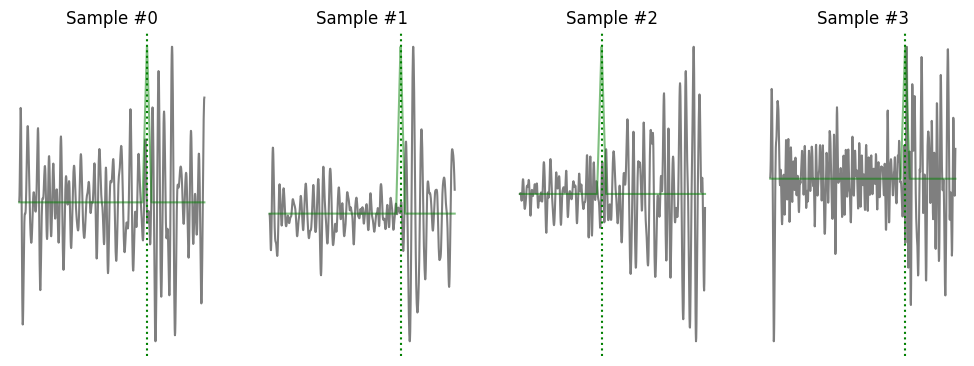

In [ ]:
fig = plt.figure(figsize=(10, 4))

for i, sample in enumerate(train_dataset):
    print(i, "waveform shape ", sample['waveform'].shape, "offset ", sample['offset'], "output shape", sample['output'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plot_sample(**sample)

    if i == 3:
        plt.show()
        break

In [ ]:
#train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=0)


In [ ]:
#next(enumerate(train_dataloader))

(0,
 {'offset': tensor([238, 338, 206, 274]),
  'waveform': tensor([[ 1.6158e+01,  1.5419e+01,  1.4456e+01,  ...,  5.4891e+01,
            5.2070e+01,  4.8319e+01],
          [ 1.3012e+01, -4.1111e+00, -8.1975e+00,  ..., -1.0349e+01,
           -1.7977e+01, -1.1459e+01],
          [-2.3074e+00, -2.3460e+00, -2.1605e+00,  ..., -4.6738e-02,
            2.2858e-02, -2.8239e-04],
          [ 1.5916e+00,  1.0678e+00, -1.2347e-01,  ..., -6.9027e-01,
           -1.7481e+00, -1.3065e+00]], dtype=torch.float64),
  'output': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
  'sr': tensor([40, 40, 40, 40])})

In [ ]:
#len(train_dataloader), len(valid_dataloader)

(12187, 3022)

## Train an RNN model

In [ ]:
import torch.nn as nn

class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()

        # Number of hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # RNN
        self.rnn = torch.nn.RNN(
            input_size = input_dim,
            hidden_size = hidden_dim,
            num_layers = layer_dim,
            nonlinearity = 'tanh',
            batch_first = True,
            bidirectional = True)

        # Readout layer
        self.fc = torch.nn.Linear(
            in_features = 2 * hidden_dim,
            out_features = output_dim
        )

    def forward(self, x):
        out, hn = self.rnn(x)
        out = self.fc(out)
        return out


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [ ]:
#train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=0)
#valid_dataloader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=0)

In [ ]:
import numpy as np
import torch
import copy
import time

SCALE = 10
SAMPLE_RATE = 40
criterion = torch.nn.MSELoss()

def eval_model(model, valid_dataloader):
  model.eval()
  all_loss, all_err = [], []
  for idx, batch in enumerate(valid_dataloader):
    waveform = torch.unsqueeze(batch['waveform'], 2).to(device)
    exp_out = (batch['output'] * SCALE).to(device)
    with torch.no_grad():
      act_out = model(waveform).squeeze(2)
      loss = criterion(act_out, exp_out)
    all_loss.append(loss.item())
    pred = act_out.to('cpu').argmax(1)
    # calculate the error in terms of seconds
    err = ((pred - batch['output'].argmax(1)) / SAMPLE_RATE).mean()
    all_err.append(err.item())
  return np.mean(all_loss), np.mean(all_err)

def train_model(model, train_dataloader, valid_dataloader, num_epochs):
  # SGD Optimizer
  learning_rate = 0.05
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  best_err, best_model_state = None, None
  for epoch in range(num_epochs):
    t1 = time.time()
    model.train()
    for idx, batch in enumerate(train_dataloader):
      waveform = torch.unsqueeze(batch['waveform'], 2).to(device)
      exp_out = (batch['output'] * SCALE).to(device)
      optimizer.zero_grad()
      act_out = model(waveform).squeeze(2)
      loss = criterion(act_out, exp_out)
      loss.backward()
      optimizer.step()
      print(f"Epoch {epoch:3d} Batch Index {idx:3d} loss {loss.data:.3f}")
    # At the end of each epoch compute the validation loss and prediction error
    val_loss, val_err = eval_model(model, valid_dataloader)
    print("Validation Loss {:.3f} Predicton Error {:.3f} sec".format(val_loss, val_err))
    if best_err is None or abs(val_err) < best_err:
      best_model_state = copy.deepcopy(model.state_dict())
      best_err = abs(val_err)
    t2 = time.time()
    print(f"Epoch completed in {t2-t1:.3f} seconds")
  # return the best model that was encountered during training
  model.load_state_dict(best_model_state)
  return model

In [ ]:
#model = train_model(
#    RNNModel(1, 100, 10, 1).double().to(device),
#    train_dataloader,
#    valid_dataloader,
#    num_epochs=20
#)

Epoch   0 Batch Index   0 loss 1.685
Epoch   0 Batch Index   1 loss 1.771
Epoch   0 Batch Index   2 loss 1.925
Epoch   0 Batch Index   3 loss 1.698
Epoch   0 Batch Index   4 loss 1.687
Epoch   0 Batch Index   5 loss 1.665
Epoch   0 Batch Index   6 loss 1.651
Epoch   0 Batch Index   7 loss 1.648
Epoch   0 Batch Index   8 loss 1.648
Epoch   0 Batch Index   9 loss 1.648
Epoch   0 Batch Index  10 loss 1.648
Epoch   0 Batch Index  11 loss 1.648
Epoch   0 Batch Index  12 loss 1.648
Epoch   0 Batch Index  13 loss 1.648
Epoch   0 Batch Index  14 loss 1.646
Epoch   0 Batch Index  15 loss 1.649
Epoch   0 Batch Index  16 loss 1.648
Epoch   0 Batch Index  17 loss 1.648
Epoch   0 Batch Index  18 loss 1.648
Epoch   0 Batch Index  19 loss 1.648
Epoch   0 Batch Index  20 loss 1.648
Epoch   0 Batch Index  21 loss 1.647
Epoch   0 Batch Index  22 loss 1.648
Epoch   0 Batch Index  23 loss 1.647
Epoch   0 Batch Index  24 loss 1.647
Epoch   0 Batch Index  25 loss 1.647
Epoch   0 Batch Index  26 loss 1.648
E